In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from ggplot import *
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [2]:
train_df = pd.read_csv("train.csv", sep=',')

# Описание набора данных

Данные описывают результаты футбольных матчей Итальянской Лиги "Серии А" за последние 8 лет. Данные включают в себя основную необходимую информацию для букмекерских компаний, в том числе коэффициенты на победу/поражение/ничью.

__Список переменных:__
 * 1 - __ID__ (идентификационный номер матча)
 * 2 - __Date__ (дата проведения матча)
 * 3 - __HomeTeam__ (команда, играющая дома)
 * 4 - __AwayTeam__ (команда, играющая на выезде)
 * 5 - __FTR__ (результат матча: H - победила домашняя команда, A - победила гостевая команда, D - ничья)
 * 6 - __B365, BW, IW, LB, WH, VC__ - сокращенное название букмекерских компаний
 * 7 - __Постфиксы в названиях компаний__:
        A - коэффициент на победу команды, играющей на выезде
        H - коэффициент на победу команды, играющей дома
        D - коэффициент на ничью
        
__Целевая переменная:__
 * 8 - __y__: Каков предполагаемый результат матча? (задача классификации непересекающихся классов)

__В чем состоит задача?__

Наша задача состоит в том, чтобы научить классификатор по обучающей выборке предсказывать результаты матчей относительно тестовой выборки.

__Зачем это?__

Вообще, довольно очевидно, что данный алгоритм будет мощным средством получения дохода, если научить его предугадывать результаты хотя бы с вероятностью больше 50-ти %. Тем не менее его применение, если вдуматься, не ограничивается только данной задачей.

__Анализ признаков__

Как мы видим, в основном признаки, которые и будут влиять на решение алгоритма предсказать тот или иной исход матча, являются вещественными. Иными словами, алгоритм должен прогнозировать на основе коэффициентов букмекеров. 

# Работа с датафреймом


## Очистка данных

Для начала, уберем строчки с пропущенными значениями, так как их отсутсвие существенно упрощает задачу, а их количество достаточно мало (относительно поличившихся объемов данных мы получаем, что потери составят всего 2,5%)

In [3]:
new_df = train_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
print(len(new_df),len(train_df))

1482 1520


## Первичный анализ данных

Теперь можно более подробно рассмореть выборку.

In [4]:
print(new_df.columns)

Index(['ID', 'Date', 'HomeTeam', 'AwayTeam', 'FTR', 'B365H', 'B365D', 'B365A',
       'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'WHH',
       'WHD', 'WHA', 'VCH', 'VCD', 'VCA'],
      dtype='object')


In [5]:
new_df.head()

,ID,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,BWD,...,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA
0,611,2013-08-24,Sampdoria,Juventus,A,8.00,4.00,1.45,7.25,4.00,...,1.55,6.00,4.00,1.53,7.00,4.00,1.50,7.50,4.0,1.55
1,612,2013-08-24,Verona,Milan,H,4.75,3.60,1.75,4.75,3.75,...,1.70,4.80,3.60,1.75,4.75,3.60,1.75,4.80,3.6,1.80
2,613,2013-08-25,Cagliari,Atalanta,H,2.50,3.00,3.00,2.45,3.10,...,3.00,2.37,3.20,3.00,2.50,3.00,3.00,2.55,3.2,3.10
3,614,2013-08-25,Inter,Genoa,H,1.62,3.75,5.50,1.60,3.75,...,4.90,1.61,3.75,5.50,1.70,3.75,4.80,1.67,3.9,5.75
4,615,2013-08-25,Lazio,Udinese,H,2.00,3.40,3.75,1.95,3.40,...,3.80,1.85,3.50,4.20,2.00,3.40,3.75,2.00,3.4,4.10


Итак, после первичного осмотра данных, можно заметить, что из себя представляют признаки на координатной плоскости, то есть необходимо осуществить их первичную визуализацию. Заметим, что график признаков: ID, Date, HomeTeam, AwayTeam не будут иметь особого смысла, поскольку это лишь бэкграунд к самой задаче классификации, то есть они на результат (кроме команд, но их название не играет роли) не влияют. Признак FTR мы рассмотрим чуть позже, так как он имеет особое значение в нашей модели. Рассматривать отдельно каждый из признаков, очевидно нет смысла, поскольку коэффициенты очень похожи среди компаний, в чем мы убедимся позже. Тогда рассмотрим для примера лишь первую компанию.

(array([   1.,    4.,  421.,  722.,  122.,  102.,   51.,   20.,   20.,
           9.,    4.,    3.,    0.,    1.,    2.]),
 array([ 1.7       ,  2.18666667,  2.67333333,  3.16      ,  3.64666667,
         4.13333333,  4.62      ,  5.10666667,  5.59333333,  6.08      ,
         6.56666667,  7.05333333,  7.54      ,  8.02666667,  8.51333333,  9.        ]),
 <a list of 15 Patch objects>)

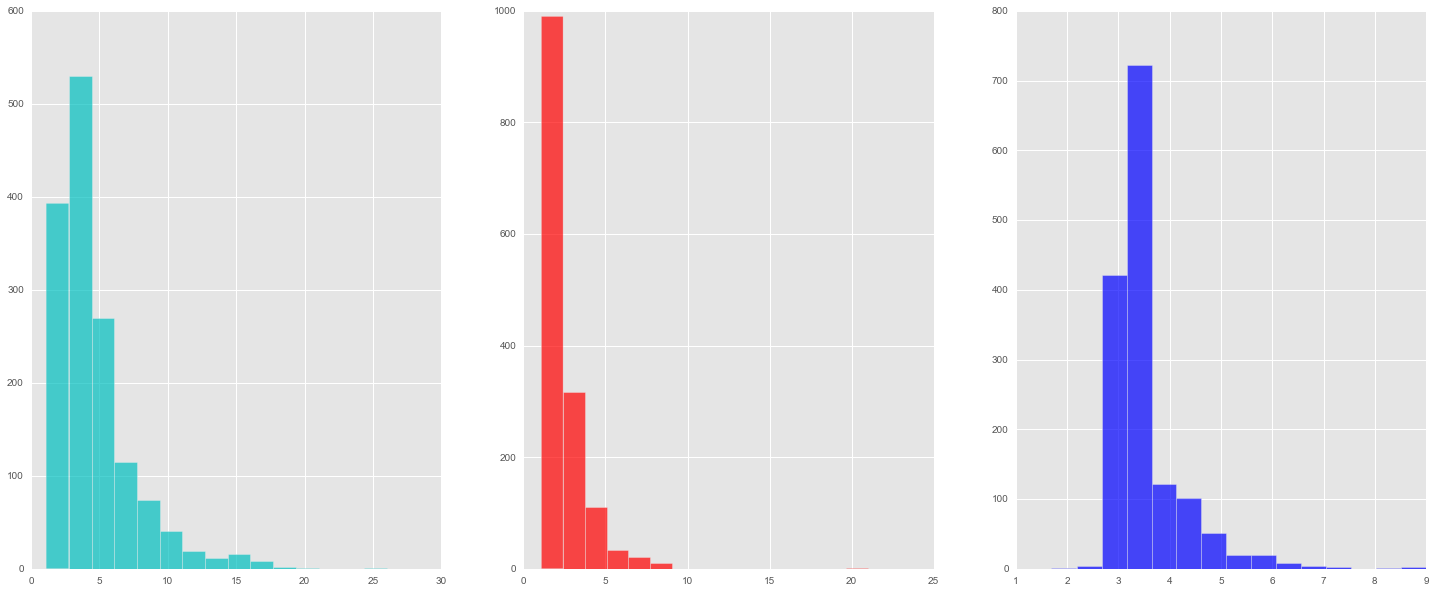

In [9]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(25,10)
ax[0].hist(new_df['B365A'], bins = 15, facecolor='c', alpha = 0.7,  label = 'A')
ax[1].hist(new_df['B365H'], bins = 15, facecolor='r', alpha = 0.7,  label = 'H')
ax[2].hist(new_df['B365D'], bins = 15, facecolor='b', alpha = 0.7,  label = 'D')

## Немного описательной статистики

In [6]:
print(new_df.shape)
new_df.describe(include = "all").T

(1482, 23)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,1482,NaN,NaN,NaN,1359.8,437.176,611,981.25,1356.5,1741.75,2128
Date,1482,336,2009-01-28,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HomeTeam,1482,27,Inter,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AwayTeam,1482,27,Roma,76,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FTR,1482,3,H,720,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B365H,1482,NaN,NaN,NaN,2.45995,1.30772,1.09,1.67,2.1,2.75,21
B365D,1482,NaN,NaN,NaN,3.53362,0.722671,1.7,3.1,3.3,3.6,9
B365A,1482,NaN,NaN,NaN,4.57241,2.91265,1.1,2.7,3.6,5.5,26
BWH,1482,NaN,NaN,NaN,2.41553,1.25266,1.08,1.65,2.05,2.7,18
BWD,1482,NaN,NaN,NaN,3.50435,0.751334,1.8,3.1,3.25,3.6,9.75


## Корреляция как инструмент анализа

Из таблицы корреляций (ниже) видно, что все букмекерские конторы выставляют схожие коэффициенты на результаты матчей. Заметим так же, что коэффициенты на ничейный результат положительно коррелируют с коэффициентами на победу команд, играющих в гостях (и отрицательно с коэффициентом на на победу команд, играющих дома)

In [80]:
train_corr = new_df.corr(method='pearson', min_periods=1)
train_corr

,ID,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA
ID,1.000000,-0.016176,-0.080526,-0.005786,-0.028291,-0.083071,-0.030943,-0.033885,-0.076723,-0.027284,-0.030938,-0.100288,-0.002163,-0.024695,0.004541,-0.006866,-0.027946,-0.085207,-0.011019
B365H,-0.016176,1.000000,-0.127488,-0.594817,0.991193,-0.123715,-0.606735,0.981267,-0.151439,-0.598876,0.981941,-0.156316,-0.602476,0.986697,-0.123497,-0.592587,0.984845,-0.126152,-0.560423
B365D,-0.080526,-0.127488,1.000000,0.813351,-0.134421,0.972288,0.810307,-0.155375,0.959585,0.815707,-0.130138,0.945220,0.816147,-0.112091,0.962824,0.826702,-0.105504,0.966284,0.832867
B365A,-0.005786,-0.594817,0.813351,1.000000,-0.603844,0.802705,0.974281,-0.619561,0.801729,0.974229,-0.601339,0.785161,0.970837,-0.588762,0.795219,0.977864,-0.583106,0.788030,0.962026
BWH,-0.028291,0.991193,-0.134421,-0.603844,1.000000,-0.132105,-0.618605,0.985854,-0.156004,-0.609411,0.988304,-0.158841,-0.612756,0.987756,-0.132597,-0.601753,0.987727,-0.132049,-0.568629
BWD,-0.083071,-0.123715,0.972288,0.802705,-0.132105,1.000000,0.797460,-0.148977,0.952922,0.798657,-0.123843,0.951240,0.803106,-0.108129,0.958957,0.817335,-0.100885,0.965995,0.830115
BWA,-0.030943,-0.606735,0.810307,0.974281,-0.618605,0.797460,1.000000,-0.633108,0.809539,0.971137,-0.614242,0.794169,0.976746,-0.600512,0.790194,0.973047,-0.594530,0.795592,0.960718
IWH,-0.033885,0.981267,-0.155375,-0.619561,0.985854,-0.148977,-0.633108,1.000000,-0.177192,-0.630424,0.982940,-0.178336,-0.629615,0.979093,-0.153276,-0.618026,0.975382,-0.153024,-0.584722
IWD,-0.076723,-0.151439,0.959585,0.801729,-0.156004,0.952922,0.809539,-0.177192,1.000000,0.821996,-0.151551,0.946169,0.813893,-0.133866,0.943344,0.822290,-0.127046,0.954087,0.836055
IWA,-0.027284,-0.598876,0.815707,0.974229,-0.609411,0.798657,0.971137,-0.630424,0.821996,1.000000,-0.607839,0.787177,0.968230,-0.594160,0.791758,0.967681,-0.587919,0.788983,0.955529


Рассмотрим данные, отражающие взаимосвязь признаков на следующих графиках (они разделены на два блока для более приятной визуализации, при этом не уменьшается репрезентативность):

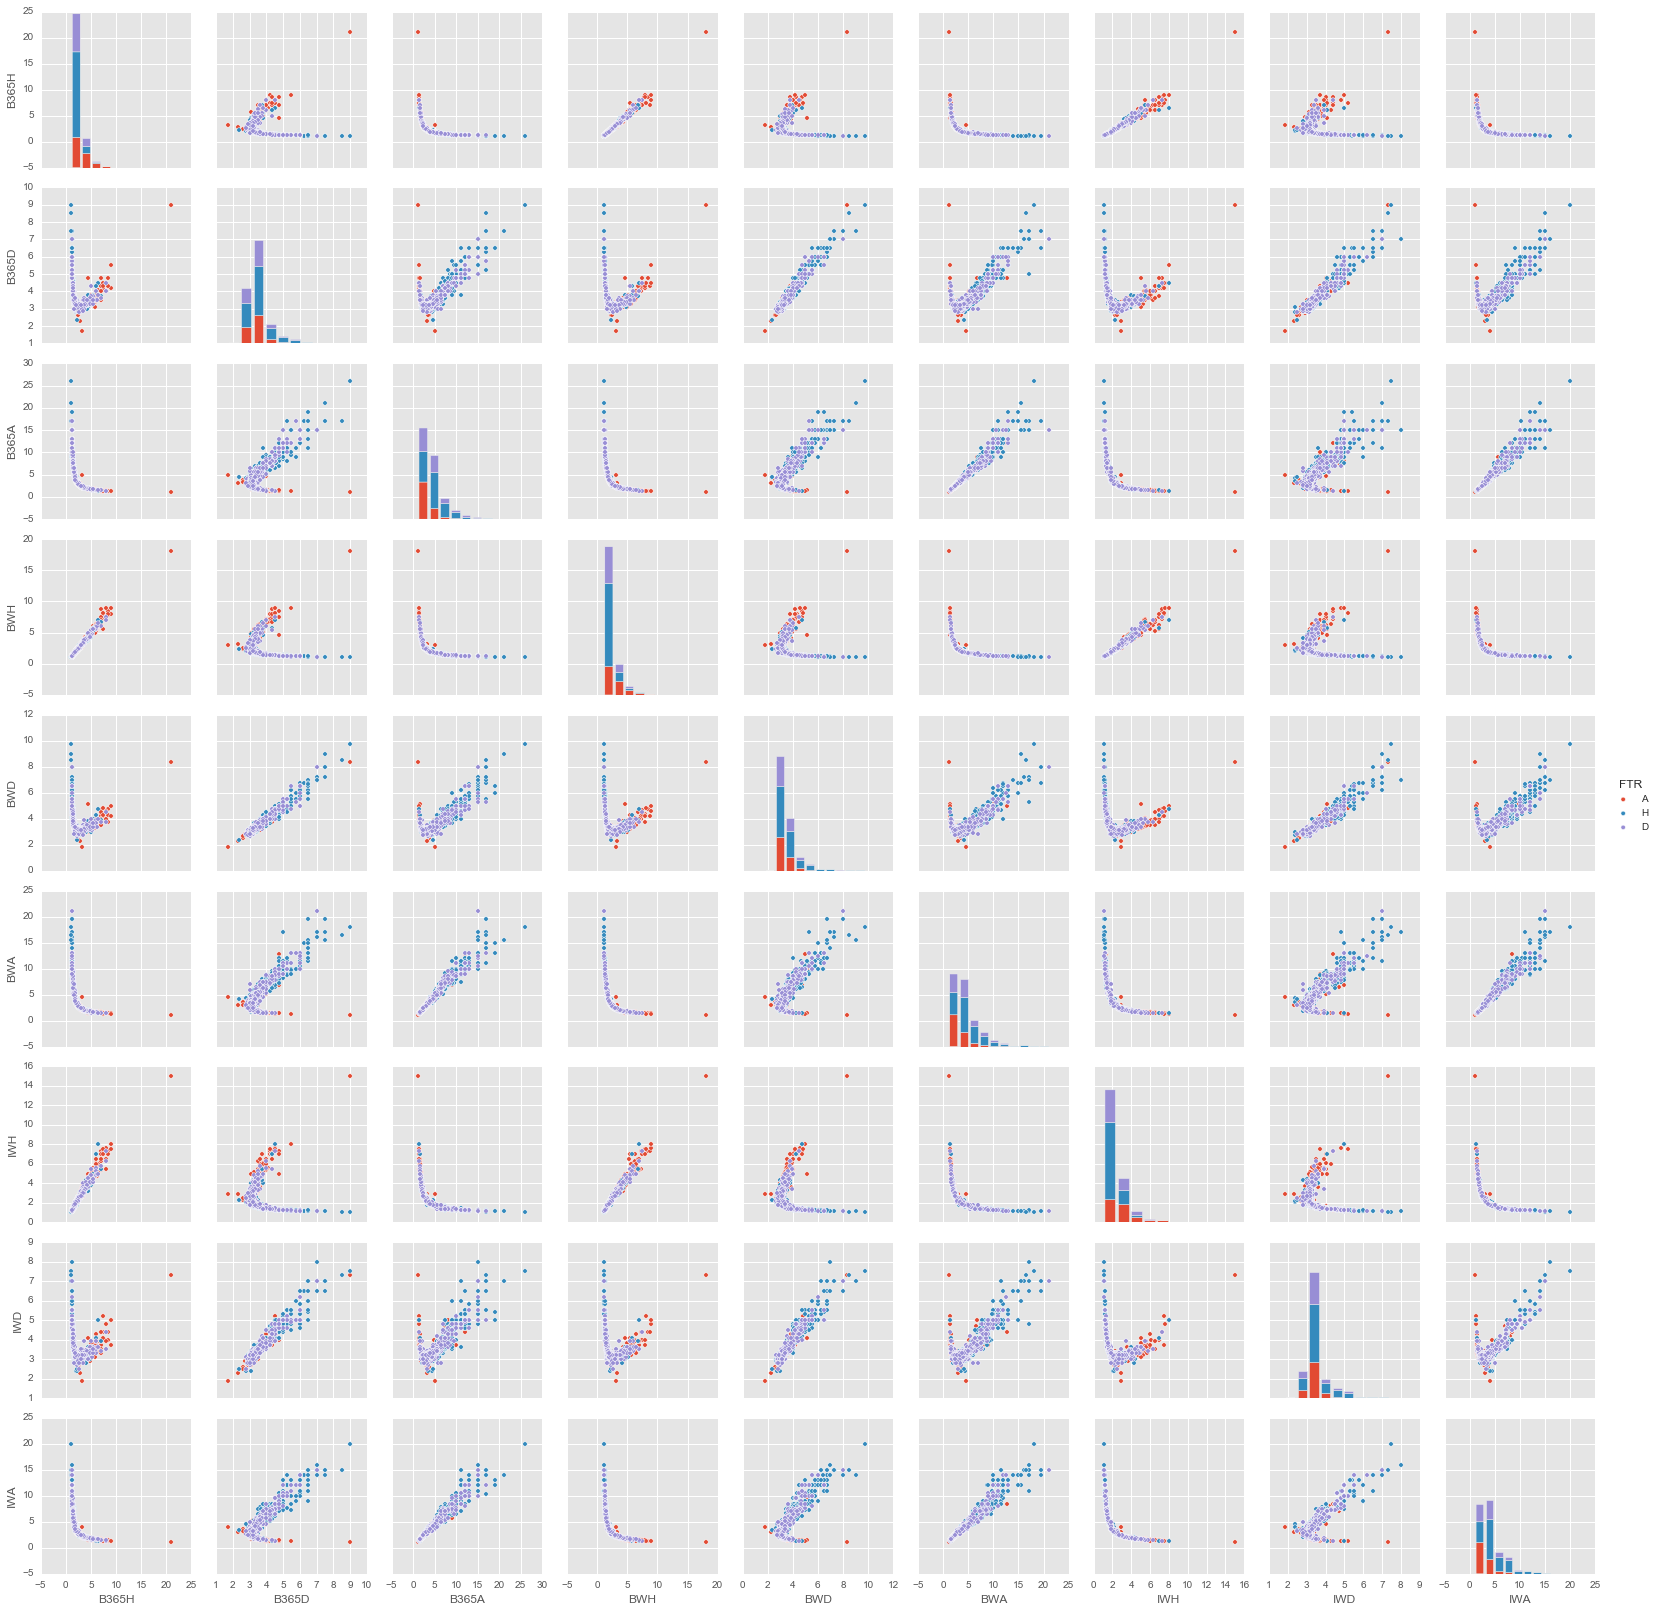

In [64]:
sns.pairplot(new_df, vars=['B365H', 'B365D', 'B365A',
       'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA'], hue="FTR")

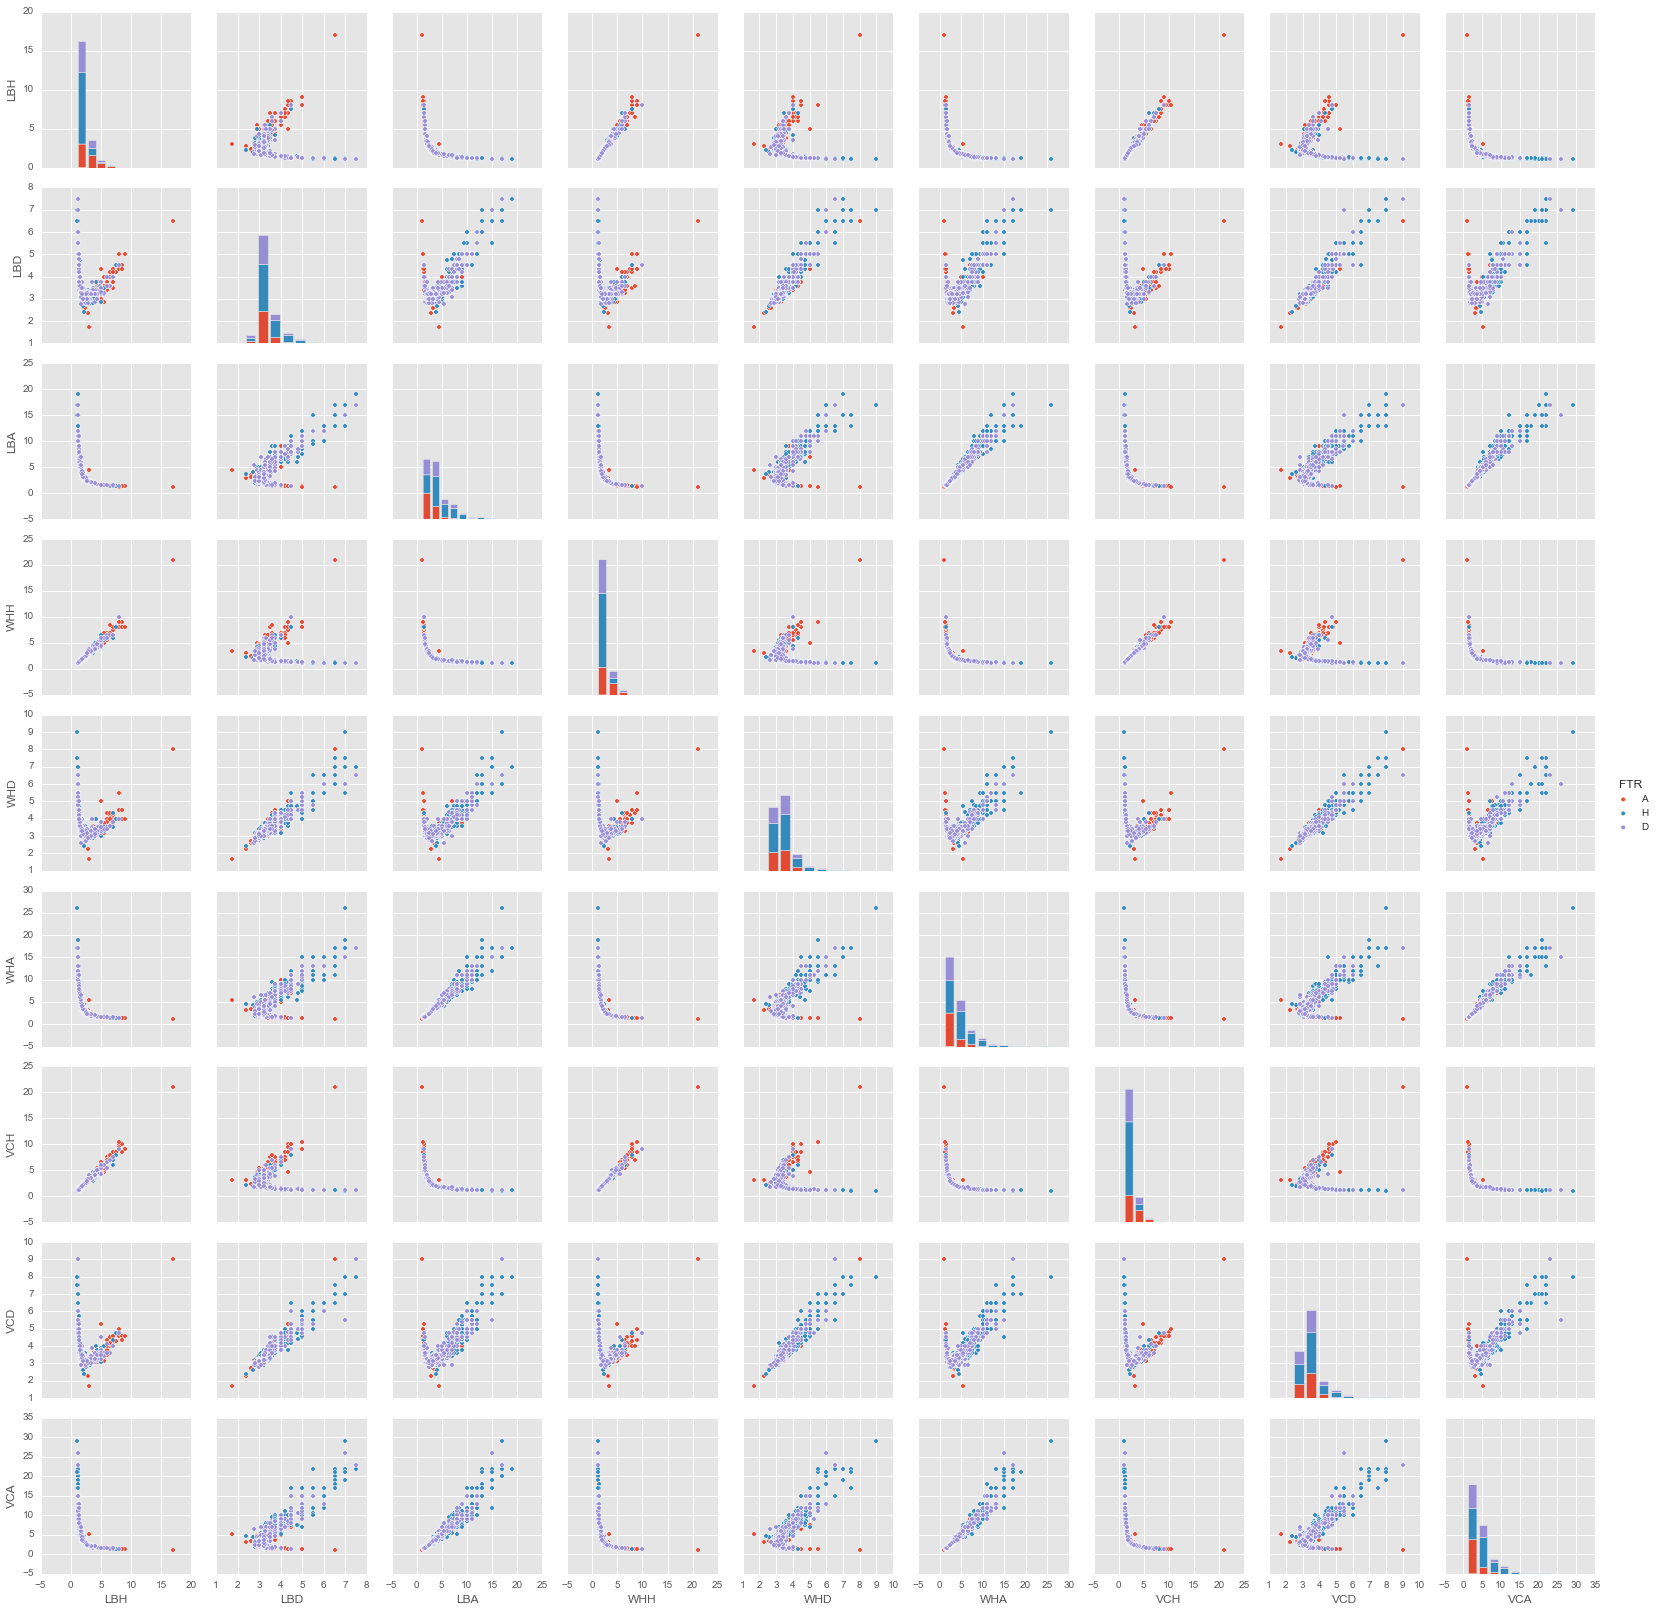

In [65]:
sns.pairplot(new_df, vars=['LBH', 'LBD', 'LBA', 'WHH',
       'WHD', 'WHA', 'VCH', 'VCD', 'VCA'], hue="FTR")

## Анализ признака FTR

Рассмотрим один из важнейших признаков нашей модели - FTR. Он, как мы знаем, отражает количество побед команд играющих дома/на выезде/ничьих.

Из графика ниже видно, что командами победный результат "на своем поле" достигается почти в два раза чаще, чем победа на выезде или ничья.

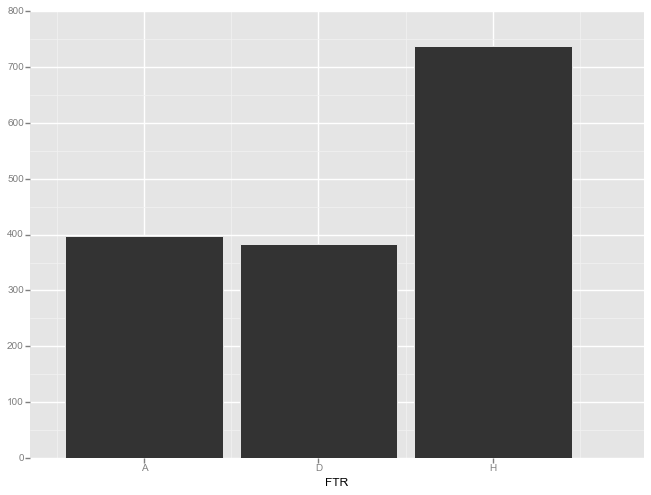

<ggplot: (279235350)>

In [20]:
ggplot(train_df, aes('FTR')) + geom_bar()

Теперь посмотрим, какие результаты предполагаются, исходя из суммарных коэффициентов.

In [24]:
columns = new_df.columns 
hsum = 0
for i in range(5, len(columns), 3):
    hsum += sum(new_df[columns[i]])
asum = 0
for i in range(6, len(columns), 3):
    asum += sum(new_df[columns[i]])
dsum = 0
for i in range(7, len(columns), 3):
    dsum += sum(new_df[columns[i]])
hprob = (1-hsum/(hsum+asum+dsum))/2
aprob = (1-asum/(hsum+asum+dsum))/2
dprob = (1-dsum/(hsum+asum+dsum))/2
a = pd.DataFrame([aprob, dprob, hprob], index = ['A', 'D', 'H'], columns = ['prob'] )
a

,prob
A,0.330643
D,0.286307
H,0.383050


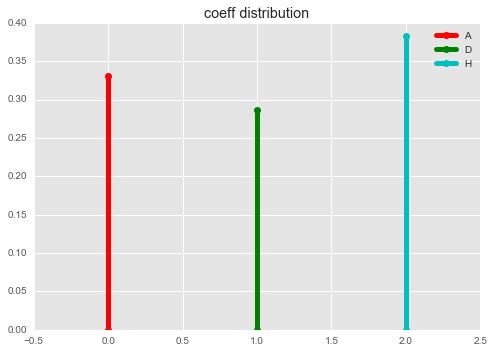

In [25]:
plt.plot((0, 0), (0, aprob), 'o-r', linewidth=5.0, label = 'A')
plt.plot((1, 1), (0, dprob), 'o-g', linewidth=5.0, label = 'D')
plt.plot((2, 2), (0, hprob), 'o-c', linewidth=5.0, label = 'H')
plt.xlim(-0.5, 2.5)
plt.title('coeff distribution')
plt.legend()
plt.show()

Сравнив два графика, видно, что вероятность победы команды, играющей дома заметно недооценена. Кроме, того, относительно вероятности победы в гостях, недооценена вероятность ничьи.

## Анализ коэффициентов среди нескольких букмекерских фирм

Рассмотрим коэффициенты на разные исходы более детально. Для начала найдем средние и мединные значения коэффициентов A, D и H (найдем среднее и медианное значения для каждой из компаний и возьмем среднее по ним)

In [26]:
hmean = 0
for i in range(5, len(columns), 3):
    hmean += mean(new_df[columns[i]])/6
    amean = 0
for i in range(6, len(columns), 3):
    amean += mean(new_df[columns[i]])/6
    dmean = 0
for i in range(7, len(columns), 3):
    dmean += mean(new_df[columns[i]])/6
    hmean, amean, dmean

In [27]:
hmedian = 0
for i in range(5, len(columns), 3):
    hmedian += median(new_df[columns[i]])/6
    amedian = 0
for i in range(6, len(columns), 3):
    amedian += median(new_df[columns[i]])/6
    dmedian = 0
for i in range(7, len(columns), 3):
    dmedian += median(new_df[columns[i]])/6
    hmedian, amedian, dmedian

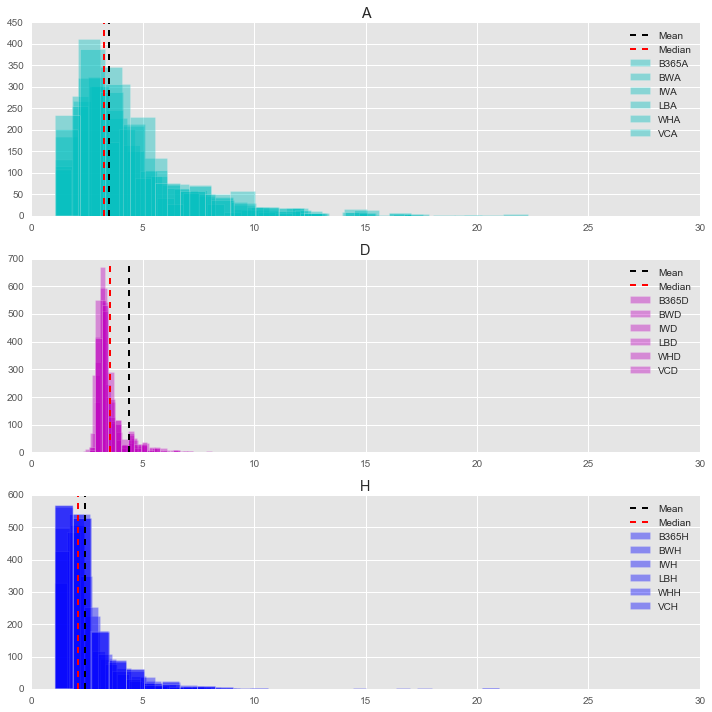

In [29]:
fig, ax = plt.subplots(3,1)
fig.set_size_inches(10,10)
ax[0].hist(new_df['B365A'], bins = 25, facecolor='c', alpha = 0.4)
ax[0].hist(new_df['BWA'], bins = 25, facecolor='c', alpha = 0.4)
ax[0].hist(new_df['IWA'], bins = 25, facecolor='c', alpha = 0.4)
ax[0].hist(new_df['LBA'], bins = 25, facecolor='c', alpha = 0.4)
ax[0].hist(new_df['WHA'], bins = 25, facecolor='c', alpha = 0.4)
ax[0].hist(new_df['VCA'], bins = 25, facecolor='c', alpha = 0.4)
ax[1].hist(new_df['B365D'], bins = 25, facecolor='m', alpha = 0.4)
ax[1].hist(new_df['BWD'], bins = 25, facecolor='m', alpha = 0.4)
ax[1].hist(new_df['IWD'], bins = 25, facecolor='m', alpha = 0.4)
ax[1].hist(new_df['LBD'], bins = 25, facecolor='m', alpha = 0.4)
ax[1].hist(new_df['WHD'], bins = 25, facecolor='m', alpha = 0.4)
ax[1].hist(new_df['VCD'], bins = 25, facecolor='m', alpha = 0.4)
ax[2].hist(new_df['B365H'], bins = 25, facecolor='b', alpha = 0.4)
ax[2].hist(new_df['BWH'], bins = 25, facecolor='b', alpha = 0.4)
ax[2].hist(new_df['IWH'], bins = 25, facecolor='b', alpha = 0.4)
ax[2].hist(new_df['LBH'], bins = 25, facecolor='b', alpha = 0.4)
ax[2].hist(new_df['WHH'], bins = 25, facecolor='b', alpha = 0.4)
ax[2].hist(new_df['VCH'], bins = 25, facecolor='b', alpha = 0.4)
ax[0].set_title('A')
ax[1].set_title('D')
ax[2].set_title('H')
ax[0].set_xlim([0, 30])
ax[1].set_xlim([0, 30])
ax[2].set_xlim([0, 30])
ax[0].axvline(amean, color='k', linestyle='dashed', linewidth=2, label ='Mean') 
ax[0].axvline(amedian, color='r', linestyle='dashed', linewidth=2, label = 'Median') 
ax[0].legend()
ax[1].axvline(dmean, color='k', linestyle='dashed', linewidth=2, label ='Mean') 
ax[1].axvline(dmedian, color='r', linestyle='dashed', linewidth=2, label = 'Median') 
ax[1].legend()
ax[2].axvline(hmean, color='k', linestyle='dashed', linewidth=2, label ='Mean') 
ax[2].axvline(hmedian, color='r', linestyle='dashed', linewidth=2, label = 'Median') 
ax[2].legend()
plt.tight_layout()
plt.show()

На вышестоящих графиках заметно, что средний коэффициент выше медианного, то есть выборке характерно присутствие "выбросов". Кроме того, заметно, что медианные значения ближе к реальности, чем средние.

## Зависимость между коэффициентами и реальными результатами матчей

Теперь рассмотрим, как соотносятся коэффициенты и реальный результат матча.


Для этого сначала нормализуем датафрейм относительно колонки FTR: это уже будет новый датафрейм norm_df.

In [19]:
norm_df = new_df.replace(['H', 'A', 'D'], [3, 0, 1]) # для значений H - 3 очка, для A - 0 и для D - 1

In [20]:
norm_df.head()

,ID,Date,HomeTeam,AwayTeam,FTR,B365H,B365D,B365A,BWH,BWD,...,IWA,LBH,LBD,LBA,WHH,WHD,WHA,VCH,VCD,VCA
0,611,2013-08-24,Sampdoria,Juventus,0,8.00,4.00,1.45,7.25,4.00,...,1.55,6.00,4.00,1.53,7.00,4.00,1.50,7.50,4.0,1.55
1,612,2013-08-24,Verona,Milan,3,4.75,3.60,1.75,4.75,3.75,...,1.70,4.80,3.60,1.75,4.75,3.60,1.75,4.80,3.6,1.80
2,613,2013-08-25,Cagliari,Atalanta,3,2.50,3.00,3.00,2.45,3.10,...,3.00,2.37,3.20,3.00,2.50,3.00,3.00,2.55,3.2,3.10
3,614,2013-08-25,Inter,Genoa,3,1.62,3.75,5.50,1.60,3.75,...,4.90,1.61,3.75,5.50,1.70,3.75,4.80,1.67,3.9,5.75
4,615,2013-08-25,Lazio,Udinese,3,2.00,3.40,3.75,1.95,3.40,...,3.80,1.85,3.50,4.20,2.00,3.40,3.75,2.00,3.4,4.10


Чтобы не загромождать график искомой зависимости, рассмотрим коэффициенты только одной компании B365 (что в любом случае будет достаточно репрезентативно ввиду высокой корреляции между коэффициентами разных компаний).
На графике по оси __X__ - классы 0, 1, 3 (победа гостей, ничья, победа домашней команды), по оси __Y__ - значения коэффицентов на результат конкретного матча (чем более темная область на графике, тем более часто встречался такой коэффициент)

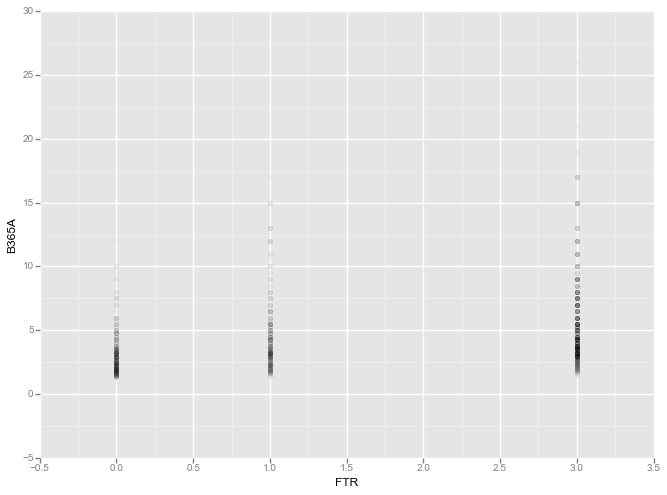

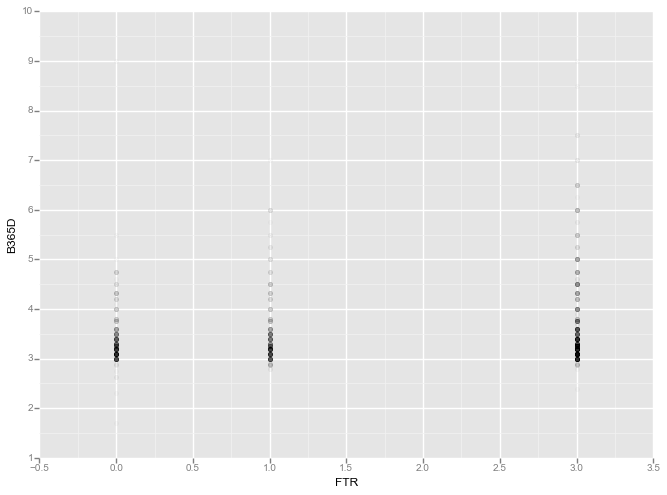

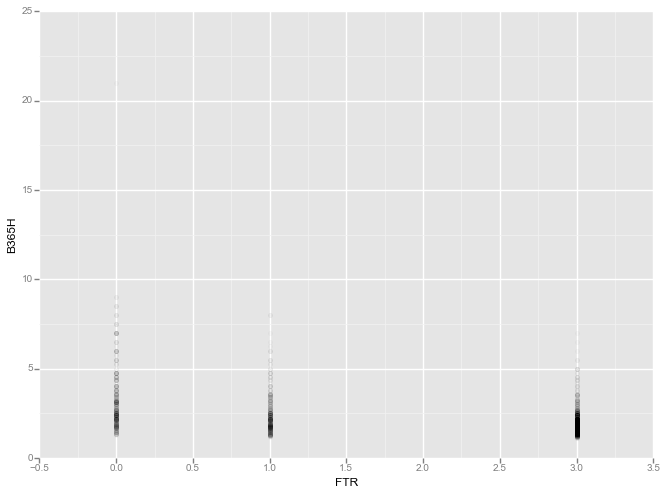

(<ggplot: (87618055593)>,
 <ggplot: (87618336839)>,
 <ggplot: (-9223371949236831544)>)

In [47]:
g1 = ggplot(norm_df, aes('FTR', 'B365A')) + geom_point(alpha=1/50)
g2 = ggplot(norm_df, aes('FTR', 'B365D')) + geom_point(alpha=1/50)
g3 = ggplot(norm_df, aes('FTR', 'B365H')) + geom_point(alpha=1/50)
g1, g2, g3

На этих графиках хорошо видно, что особенно затруднительно предугадать результат матча, основываясь только лишь на коэффициентах. 
В частности, коэффициенты на ничью почти всегда выше, чем на победу одной из команд, то есть если просто выбирать результат на который выставлен наименьший коэффициент, то мы практически никогда не предугадаем ничью. Ко всему прочему, при любом из исходов, коэффициенты на ничью распределены примерно одинаково (график 2).
Более того, графики 1 и 3 подтверждают то, что ни низкий, ни высокий коэффициенты не являются гарантом правильности выбора, то есть нередко можно проиграть, поставив на матч с низким коэффициентом победу, и выиграть, поставив на матч с высоким коэффициентом (хотя такое наблюдается реже).

## Предобработка данных

Как Вы могли видеть выше, на данный момент мы сделали следующие изменения в датафрейме:
* удалили все строчки, в которых имеет место отсуствие данных (NaN): их малое количество очень незначительно повляет на результаты
* заменили в признаке FTR значения H/A/D на 3/0/1 (для анализа зависимости победителя и минимальной ставки компании)

Стоит отметить, что мы не делим изначальную выборку на обучающую и тестовую, поскольку используемые данные уже поделены, т.е. отдельным файлом предоставлялась test-выборка, содержащая коэффициенты, по которым наш классификатор должен делать прогнозы.